In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных

In [3]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.datasets import QM9

# Load the QM9 dataset
dataset = QM9(root='./data/QM9')

print(f"Dataset: {dataset}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Extracting data/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Dataset: QM9(130831)
Number of features: 11
Number of classes: 19


In [4]:
def process_graph_data(data):
    aggregated_features = torch.sum(data.x, dim=0)

    homo_lumo_gap = data.y[0, 4]

    return aggregated_features, homo_lumo_gap

features_list = []
targets_list = []

for i, data_object in enumerate(dataset):
    aggregated_features, homo_lumo_gap = process_graph_data(data_object)
    features_list.append(aggregated_features)
    targets_list.append(homo_lumo_gap)

all_features = torch.stack(features_list)
all_targets = torch.stack(targets_list)

print(f"Shape of all_features: {all_features.shape}")
print(f"Shape of all_targets: {all_targets.shape}")

print("First 5 aggregated features:")
print(all_features[:5])
print("First 5 HOMO-LUMO gap targets:")
print(all_targets[:5])

Shape of all_features: torch.Size([130831, 11])
Shape of all_targets: torch.Size([130831])
First 5 aggregated features:
tensor([[ 4.,  1.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  4.],
        [ 3.,  0.,  1.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  3.],
        [ 2.,  0.,  0.,  1.,  0., 10.,  0.,  0.,  0.,  0.,  2.],
        [ 2.,  2.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  2.],
        [ 1.,  1.,  1.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  1.]])
First 5 HOMO-LUMO gap targets:
tensor([13.7363,  9.2491,  9.8369,  9.1185, 10.3294])


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_targets, test_size=0.2, random_state=42
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in test_dataset: {len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Shape of X_train: torch.Size([104664, 11])
Shape of y_train: torch.Size([104664])
Shape of X_test: torch.Size([26167, 11])
Shape of y_test: torch.Size([26167])
Number of samples in train_dataset: 104664
Number of samples in test_dataset: 26167
Number of batches in train_loader: 3271
Number of batches in test_loader: 818


# Модель и обучение

In [6]:
# Get the input dimension from the processed features
# X_train.shape[1] gives the number of features per sample
input_dim = X_train.shape[1]

class MLPRegression(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegression, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = MLPRegression(input_dim)

print(model)


MLPRegression(
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [7]:
import torch.optim as optim

criterion = nn.MSELoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

num_epochs = 200

train_losses = []
train_maes = []

mae_criterion = nn.L1Loss()

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    current_epoch_loss = 0.0
    current_epoch_mae = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float())

        loss = criterion(outputs.squeeze(), labels.float())

        mae = mae_criterion(outputs.squeeze(), labels.float())

        loss.backward()

        optimizer.step()

        current_epoch_loss += loss.item()
        current_epoch_mae += mae.item()

    avg_epoch_loss = current_epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    avg_epoch_mae = current_epoch_mae / len(train_loader)
    train_maes.append(avg_epoch_mae)

    if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {avg_epoch_loss:.4f}, MAE: {avg_epoch_mae:.4f}")

print("Training finished.")

Using device: cpu
Starting training...
Epoch [1/200], MSE Loss: 1.4334, MAE: 0.9182
Epoch [5/200], MSE Loss: 1.0272, MAE: 0.8317
Epoch [10/200], MSE Loss: 0.9900, MAE: 0.8162
Epoch [15/200], MSE Loss: 0.9848, MAE: 0.8135
Epoch [20/200], MSE Loss: 0.9787, MAE: 0.8113
Epoch [25/200], MSE Loss: 0.9742, MAE: 0.8088
Epoch [30/200], MSE Loss: 0.9713, MAE: 0.8074
Epoch [35/200], MSE Loss: 0.9676, MAE: 0.8060
Epoch [40/200], MSE Loss: 0.9653, MAE: 0.8049
Epoch [45/200], MSE Loss: 0.9637, MAE: 0.8036
Epoch [50/200], MSE Loss: 0.9631, MAE: 0.8038
Epoch [55/200], MSE Loss: 0.9619, MAE: 0.8033
Epoch [60/200], MSE Loss: 0.9617, MAE: 0.8030
Epoch [65/200], MSE Loss: 0.9604, MAE: 0.8022
Epoch [70/200], MSE Loss: 0.9600, MAE: 0.8020
Epoch [75/200], MSE Loss: 0.9607, MAE: 0.8025
Epoch [80/200], MSE Loss: 0.9596, MAE: 0.8015
Epoch [85/200], MSE Loss: 0.9589, MAE: 0.8013
Epoch [90/200], MSE Loss: 0.9596, MAE: 0.8018
Epoch [95/200], MSE Loss: 0.9596, MAE: 0.8023
Epoch [100/200], MSE Loss: 0.9587, MAE: 0.8

# Оценка

In [9]:
import torch
import torch.nn as nn

model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs.float())

        outputs = outputs.squeeze()

        all_predictions.append(outputs.cpu())
        all_true_labels.append(labels.cpu())

all_predictions = torch.cat(all_predictions).float()
all_true_labels = torch.cat(all_true_labels).float()

mse_criterion = nn.MSELoss()
mse = mse_criterion(all_predictions, all_true_labels)

mae_criterion = nn.L1Loss()
mae = mae_criterion(all_predictions, all_true_labels)

rmse = torch.sqrt(mse)

print(f"Model Evaluation on Test Set:")
print(f"MSE: {mse.item():.4f}")
print(f"MAE: {mae.item():.4f}")
print(f"RMSE: {rmse.item():.4f}")

Model Evaluation on Test Set:
MSE: 0.9631
MAE: 0.7985
RMSE: 0.9814


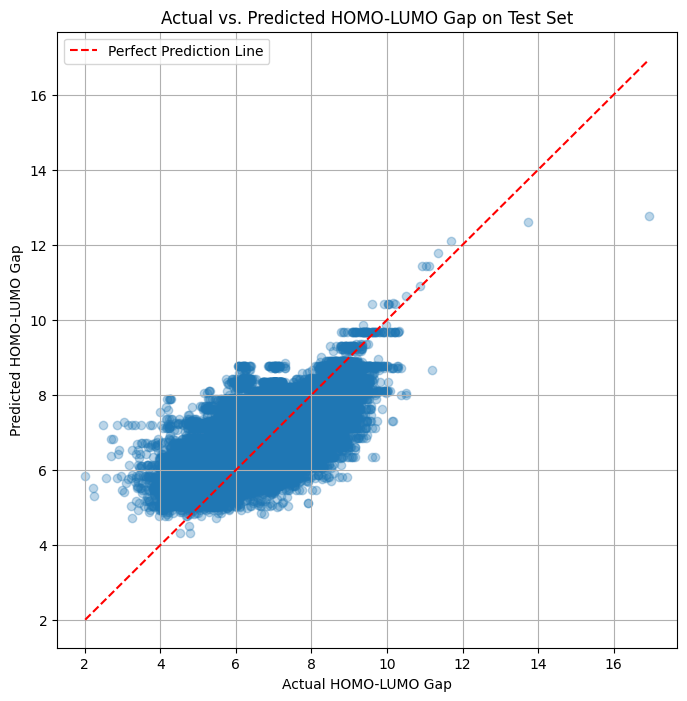

In [10]:
import matplotlib.pyplot as plt

actual_values = all_true_labels.numpy()
predicted_values = all_predictions.numpy()

plt.figure(figsize=(8, 8))
plt.scatter(actual_values, predicted_values, alpha=0.3)

plt.xlabel('Actual HOMO-LUMO Gap')
plt.ylabel('Predicted HOMO-LUMO Gap')
plt.title('Actual vs. Predicted HOMO-LUMO Gap on Test Set')

min_val = min(actual_values.min(), predicted_values.min())
max_val = max(actual_values.max(), predicted_values.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction Line')

plt.legend()
plt.grid(True)
plt.show()
